In [54]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data_path_val = 'data/renewables.ninja'
data_path = 'data/synthetic/wind'

In [19]:
# get validationd data
files = os.listdir(data_path_val)
station_files = [f for f in files if 'metadata' not in f and f.endswith('.csv')]
metadata_files = [f for f in files if 'metadata' in f and f.endswith('.csv')]
station_files.sort()
metadata_files.sort()
print(len(station_files), 'station files in validation data found')

files = os.listdir(data_path)
station_files_synthetic = [f for f in files if 'metadata' not in f and f.endswith('.csv')]
station_files_synthetic.sort()
print(len(station_files_synthetic), 'station files in synthetic data found')

39 station files in validation data found
39 station files in synthetic data found


In [ ]:
val_dfs = []
dfs = []

for st, md in zip(station_files, metadata_files):
    station = pd.read_csv(os.path.join(data_path_val, st))
    station['datetime'] = pd.to_datetime(station['datetime'])
    station.set_index('datetime', inplace=True)
    #metadata = pd.read_csv(os.path.join(path, md))
    val_dfs.append(station)

for st in station_files_synthetic:
    station = pd.read_csv(os.path.join(data_path, st), sep=';')
    station['timestamp'] = pd.to_datetime(station['timestamp'])
    station.set_index('timestamp', inplace=True)
    station = station['2024-01-01':'2025-01-01']
    #metadata = pd.read_csv(os.path.join(path, md))
    dfs.append(station)

# get turbine names via metadata
metadata = pd.read_csv(os.path.join(data_path_val, metadata_files[0]))
metadata['turbine'] = 'electricity_' + metadata['turbine'].astype(str)
mapping = metadata.set_index('turbine')['turbine_type'].to_dict()

In [57]:
val_dfs[0].index.hour

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       ...
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype='int32', name='datetime', length=8784)

<Axes: xlabel='wind_speed_1', ylabel='electricity_1'>

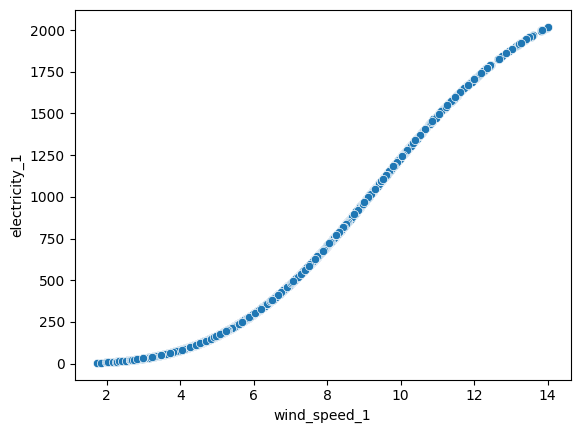

In [59]:
sns.scatterplot(data=val_dfs[0], x='wind_speed_1', y='electricity_1')

In [ ]:
dfs[0]

,wind_speed,temperature_2m,relative_humidity,std_v_wind,pressure,wind_direction,w_vert,wind_speed_hub,temperature_hub,saturated_vapor_pressure,saturated_vapor_pressure_hub,density,density_hub,Enercon E-70 E4 2.300,Enercon E-82 E2 2.000,Enercon E-115 2.500,Vestas V90,Vestas V112-3.45,Vestas V80-1.8
timestamp,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,2.883333,4.583333,0.900333,0.383333,997.700000,186.666667,-0.000442,3.07,4.090093,847.542081,818.726292,1.247835,1.238415,19454.370070,28764.942424,61580.263669,0.000000,16873.048374,0.000000
2024-01-01 01:00:00+00:00,3.100000,4.466667,0.890500,0.450000,997.700000,185.000000,-0.000536,3.32,3.973427,840.646470,812.038542,1.248428,1.239000,27546.627464,42413.155581,80104.825705,0.000000,39803.773656,0.000000
2024-01-01 02:00:00+00:00,2.433333,4.500000,0.880167,0.433333,997.516667,183.333333,-0.000642,2.65,4.006760,842.611564,813.944379,1.248081,1.238656,9433.444479,17385.613397,0.000000,0.000000,0.000000,0.000000
2024-01-01 03:00:00+00:00,2.416667,4.150000,0.889833,0.400000,997.483333,176.666667,-0.000681,2.63,3.656760,822.179251,794.129038,1.249662,1.240214,9807.510667,13319.651048,0.000000,0.000000,0.000000,0.000000
2024-01-01 04:00:00+00:00,1.933333,3.950000,0.890000,0.350000,997.400000,166.666667,-0.000531,2.11,3.456760,810.701482,782.998678,1.250507,1.241046,0.000000,4435.601710,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00+00:00,4.283333,3.066667,0.825667,1.166667,1012.133333,228.333333,-0.000290,4.47,2.573427,761.685797,735.473532,1.273530,1.263863,79978.986522,133810.989067,236759.215629,139224.435819,195128.207325,57447.912540
2024-12-31 20:00:00+00:00,4.583333,3.716667,0.816000,1.083333,1011.550000,226.666667,-0.000339,4.79,3.223427,797.490086,770.187915,1.269702,1.260087,103017.034052,148112.614227,280013.864164,209873.714515,255061.105767,82566.225441
2024-12-31 21:00:00+00:00,3.900000,3.366667,0.829333,0.916667,1010.983333,218.333333,-0.000456,4.12,2.873427,778.030084,751.319525,1.270621,1.260988,54934.531831,110277.592498,179643.438271,98779.093456,159197.166826,21358.651718
